# **Abstract**

DistilBert was used to classify wikipedia abstracts as historical and non historical. A total of 210000 samples were used to train and validate the model. An outstanding performance from the model was obtained with 99.76% reported accuracy. The model was further tested with random wikipedia abstracts, proving actually useful and accurate in the task of classification

## Model Setup

In [ ]:
!pip install transformers datasets tensorflow numpy pandas
!pip install -q tensorboard

import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from transformers import (
    DistilBertTokenizer,
    TFDistilBertForSequenceClassification,
    create_optimizer
)
import tensorflow as tf
from sklearn.model_selection import train_test_split
import datetime

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Info:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Info: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

# 1. Data Loading and Preprocessing
def load_and_prepare_data(max_samples=None):
    """Load and prepare the dataset with optional size limit"""
    dataset = load_dataset('guscastilloa/dbpedia_historical_events')
    df = pd.DataFrame(dataset['train'])

    if max_samples:
        df = df.sample(n=max_samples, random_state=42)

    # Combine title and abstract if they exist, otherwise use text
    df['processed_text'] = df['text'].apply(lambda x: x[:512])  # Truncate to manage length

    return df

# 2. Create Train/Val Split
def create_train_val_split(df, val_size=0.2):
    """Create stratified train/validation split"""
    train_df, val_df = train_test_split(
        df,
        test_size=val_size,
        stratify=df['label'],
        random_state=42
    )
    return train_df, val_df

# 3. Data Processing
class DataProcessor:
    def __init__(self, max_length=128):
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.max_length = max_length

    def prepare_tf_dataset(self, texts, labels, batch_size=32):
        """Convert to TF Dataset with proper batching and prefetching"""
        encodings = self.tokenizer(
            list(texts),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='tf'
        )

        dataset = tf.data.Dataset.from_tensor_slices((
            {
                'input_ids': encodings['input_ids'],
                'attention_mask': encodings['attention_mask']
            },
            labels
        ))

        return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 4. Model Setup
def create_model():
    """Create and compile the model"""
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2
    )

    #optimizer = create_optimizer(2e-5, num_train_steps=1000, num_warmup_steps=100)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

def save_model_weights(model, path):
    """Save model weights"""
    model.save_weights(path)
    print(f"Model weights saved to {path}")

def load_model_weights(path):
    """Load model weights into a new model instance"""
    model = create_model()
    model.load_weights(path)
    return model

# 5. Training Function
def train_model(model, train_dataset, val_dataset, epochs=3, callbacks = None):
    """Train the model with callbacks"""
    if callbacks is None:
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=2,
                restore_best_weights=True
            )
        ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

In [ ]:
# Set up TensorBoard for monitoring
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq='epoch'
)

# Memory monitoring
def print_memory_usage():
    import psutil
    print(f"RAM Memory Usage: {psutil.Process().memory_info().rss / 1024 / 1024:.2f} MB")

In [ ]:
def main(max_samples=None, batch_size=32, epochs=3):


    # Create output directory for model artifacts
    from pathlib import Path
    output_dir = Path('/content/model_outputs')
    output_dir.mkdir(exist_ok=True)


    # Load and prepare data
    print("Loading data...")
    print_memory_usage()
    df = load_and_prepare_data(max_samples)
    print(f"Dataset size: {len(df)}")
    print(f"Label distribution:\n{df['label'].value_counts(normalize=True)}")

    train_df, val_df = create_train_val_split(df)
    print(f"\nTrain size: {len(train_df)}, Validation size: {len(val_df)}")
    print_memory_usage()

    # Initialize processor
    print("\nProcessing data...")
    processor = DataProcessor()
    train_dataset = processor.prepare_tf_dataset(
        train_df['processed_text'],
        train_df['label'],
        batch_size
    )
    val_dataset = processor.prepare_tf_dataset(
        val_df['processed_text'],
        val_df['label'],
        batch_size
    )
    print_memory_usage()

    # Create and train model
    print("\nTraining model...")
    model = create_model()

    # Add callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
        ),
        tensorboard_callback,
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=1
        )
    ]

    history = train_model(model, train_dataset, val_dataset, epochs, callbacks)

    # Save model weights and tokenizer
    weights_path = output_dir / 'model_weights'
    model.save_weights(str(weights_path))
    print(f"Model weights saved to {weights_path}")

    return model, history

In [ ]:
# Add this as a new cell after the training cell
def setup_colab_storage():
    """Setup storage for model artifacts in Colab"""
    from google.colab import drive
    import shutil

    # Option 1: Mount Google Drive
    print("Do you want to mount Google Drive to save model artifacts? (y/n)")
    if input().lower() == 'y':
        drive.mount('/content/drive')
        output_dir = Path('/content/drive/MyDrive/historical_events_model')
        output_dir.mkdir(exist_ok=True)
        print(f"Model artifacts will be saved to: {output_dir}")
        return output_dir

    # Option 2: Use local Colab storage with download option
    output_dir = Path('/content/model_outputs')
    output_dir.mkdir(exist_ok=True)
    print(f"Model artifacts will be saved to: {output_dir}")
    return output_dir

def download_model_artifacts(output_dir):
    """Create downloadable zip of model artifacts"""
    from google.colab import files
    import shutil

    # Create zip file of model outputs
    shutil.make_archive('model_artifacts', 'zip', output_dir)

    # Download the zip file
    files.download('model_artifacts.zip')

In [ ]:
# Plot test results
import matplotlib.pyplot as plt
def plot_training_history(history):
    """Plot training history with proper handling of single-epoch cases"""
    metrics = history.history
    epochs = range(1, len(metrics['accuracy']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(epochs, metrics['accuracy'], 'bo-', label='Train')
    ax1.plot(epochs, metrics['val_accuracy'], 'ro-', label='Validation')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(epochs, metrics['loss'], 'bo-', label='Train')
    ax2.plot(epochs, metrics['val_loss'], 'ro-', label='Validation')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print metrics
    print("\nFinal metrics:")
    print(f"Train Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {metrics['val_accuracy'][-1]:.4f}")
    print(f"Train Loss: {metrics['loss'][-1]:.4f}")
    print(f"Validation Loss: {metrics['val_loss'][-1]:.4f}")

In [ ]:
def predict_historical_event(model, processor, text, show_probabilities=True):
    """
    Make prediction for a single text input

    Args:
        model: Trained model
        processor: DataProcessor instance
        text: Input text to classify
        show_probabilities: Whether to show class probabilities
    """
    # Prepare the input
    inputs = processor.tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=processor.max_length,
        return_tensors='tf'
    )

    # Make prediction
    outputs = model(inputs)
    probabilities = tf.nn.softmax(outputs.logits, axis=-1)
    predicted_class = tf.argmax(probabilities, axis=-1)[0]

    # Print results
    print(f"\nInput text: {text}")
    print(f"Prediction: {'Historical Event' if predicted_class == 1 else 'Not Historical Event'}")

    if show_probabilities:
        probs = probabilities[0].numpy()
        print(f"\nProbabilities:")
        print(f"Not Historical Event: {probs[0]:.4f}")
        print(f"Historical Event: {probs[1]:.4f}")

    return predicted_class, probabilities


## Test run 210.000 samples 5 epochs

Loading data...
RAM Memory Usage: 1036.21 MB


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset size: 210000
Label distribution:
label
0    0.513538
1    0.486462
Name: proportion, dtype: float64

Train size: 168000, Validation size: 42000
RAM Memory Usage: 1359.40 MB

Processing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RAM Memory Usage: 2162.52 MB

Training model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
5250/5250 [==============================] - 2362s 445ms/step - loss: 0.0184 - accuracy: 0.9954 - val_loss: 0.0106 - val_accuracy: 0.9971 - lr: 2.0000e-05
Epoch 2/5
5250/5250 [==============================] - 2326s 443ms/step - loss: 0.0085 - accuracy: 0.9979 - val_loss: 0.0143 - val_accuracy: 0.9971 - lr: 2.0000e-05
Epoch 3/5
5250/5250 [==============================] - 2327s 443ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0104 - val_accuracy: 0.9975 - lr: 4.0000e-06
Epoch 4/5
5250/5250 [==============================] - 2327s 443ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0115 - val_accuracy: 0.9974 - lr: 4.0000e-06
Epoch 5/5
5250/5250 [==============================] - 2327s 443ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0126 - val_accuracy: 0.9976 - lr: 8.0000e-07
Model weights saved to /content/model_outputs/model_weights


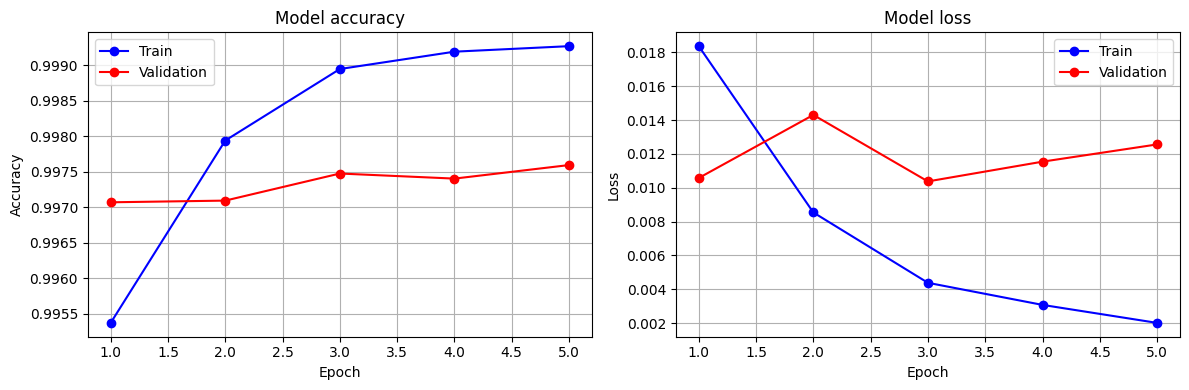


Final metrics:
Train Accuracy: 0.9993
Validation Accuracy: 0.9976
Train Loss: 0.0020
Validation Loss: 0.0126


NameError: name 'output_dir' is not defined

In [ ]:
# Let's try with a larger sample but still manageable
# This will help us validate if the model maintains performance with more data
model, history = main(
    max_samples=210000,  # 10x more samples
    batch_size=32,      # slightly larger batch
    epochs=5           # more epochs to see learning curve
)
plot_training_history(history)

# Download artifacts
download_model_artifacts('./output')

In [ ]:
download_model_artifacts('./')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Testing the model with random Wikipedia abstracts**

In [ ]:
processor = DataProcessor()
predict_historical_event(model, processor ,"The Battle of the Bulge, also known as the Ardennes Offensive, was the last major German offensive campaign on the Western Front during the Second World War which took place from 16 December 1944 to 25 January 1945.[16] It was launched through the densely forested Ardennes region between Belgium and Luxembourg. The offensive was intended to stop Allied use of the Belgian port of Antwerp and to split the Allied lines, allowing the Germans to encircle and destroy each of the four Allied armies and force the western Allies to negotiate a peace treaty in the Axis powers' favour.")


Input text: The Battle of the Bulge, also known as the Ardennes Offensive, was the last major German offensive campaign on the Western Front during the Second World War which took place from 16 December 1944 to 25 January 1945.[16] It was launched through the densely forested Ardennes region between Belgium and Luxembourg. The offensive was intended to stop Allied use of the Belgian port of Antwerp and to split the Allied lines, allowing the Germans to encircle and destroy each of the four Allied armies and force the western Allies to negotiate a peace treaty in the Axis powers' favour.
Prediction: Historical Event

Probabilities:
Not Historical Event: 0.0001
Historical Event: 0.9999


(<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[7.5944074e-05, 9.9992406e-01]], dtype=float32)>)

In [ ]:
predict_historical_event(model, processor ,"Westfield Fountain Gate is a super-regional shopping centre located in Narre Warren in the south-eastern suburbs of Melbourne, Australia. It is the second largest shopping centre in Australia by both floor area and number of anchor tenants. However, it is the largest shopping centre in Australia with all 3 discount department stores, Big W, Target and Kmart. ")


Input text: Westfield Fountain Gate is a super-regional shopping centre located in Narre Warren in the south-eastern suburbs of Melbourne, Australia. It is the second largest shopping centre in Australia by both floor area and number of anchor tenants. However, it is the largest shopping centre in Australia with all 3 discount department stores, Big W, Target and Kmart. 
Prediction: Not Historical Event

Probabilities:
Not Historical Event: 1.0000
Historical Event: 0.0000


(<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.9995232e-01, 4.7670732e-05]], dtype=float32)>)

In [ ]:
predict_historical_event(model, processor ,"Blue is one of the three primary colours in the RYB colour model (traditional colour theory), as well as in the RGB (additive) colour model.[2] It lies between violet and cyan on the spectrum of visible light. The term blue generally describes colours perceived by humans observing light with a dominant wavelength that's between approximately 450 and 495 nanometres. Most blues contain a slight mixture of other colours; azure contains some green, while ultramarine contains some violet. The clear daytime sky and the deep sea appear blue because of an optical effect known as Rayleigh scattering. An optical effect called the Tyndall effect explains blue eyes. Distant objects appear more blue because of another optical effect called aerial perspective. ")


Input text: Blue is one of the three primary colours in the RYB colour model (traditional colour theory), as well as in the RGB (additive) colour model.[2] It lies between violet and cyan on the spectrum of visible light. The term blue generally describes colours perceived by humans observing light with a dominant wavelength that's between approximately 450 and 495 nanometres. Most blues contain a slight mixture of other colours; azure contains some green, while ultramarine contains some violet. The clear daytime sky and the deep sea appear blue because of an optical effect known as Rayleigh scattering. An optical effect called the Tyndall effect explains blue eyes. Distant objects appear more blue because of another optical effect called aerial perspective. 
Prediction: Not Historical Event

Probabilities:
Not Historical Event: 0.9999
Historical Event: 0.0001


(<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.9992085e-01, 7.9134494e-05]], dtype=float32)>)

In [ ]:
predict_historical_event(model, processor ,"The Battle of the Little Bighorn, known to the Lakota and other Plains Indians as the Battle of the Greasy Grass,[1][2] and commonly referred to as Custers Last Stand, was an armed engagement between combined forces of the Lakota Sioux, Northern Cheyenne, and Arapaho tribes and the 7th Cavalry Regiment of the United States Army. It took place on June 25–26, 1876, along the Little Bighorn River in the Crow Indian Reservation in southeastern Montana Territory. The battle, which resulted in the defeat of U.S. forces, was the most significant action of the Great Sioux War of 1876.[3]")


Input text: The Battle of the Little Bighorn, known to the Lakota and other Plains Indians as the Battle of the Greasy Grass,[1][2] and commonly referred to as Custers Last Stand, was an armed engagement between combined forces of the Lakota Sioux, Northern Cheyenne, and Arapaho tribes and the 7th Cavalry Regiment of the United States Army. It took place on June 25–26, 1876, along the Little Bighorn River in the Crow Indian Reservation in southeastern Montana Territory. The battle, which resulted in the defeat of U.S. forces, was the most significant action of the Great Sioux War of 1876.[3]
Prediction: Historical Event

Probabilities:
Not Historical Event: 0.0000
Historical Event: 1.0000


(<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.5836787e-05, 9.9997413e-01]], dtype=float32)>)